In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import *
import matplotlib.cm as cm
from IPython.display import display
from tqdm import tqdm


font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

## Brownian motion

In [5]:
def pdf( D, x,t,x0,t0 ):
    return 1 / np.sqrt(4 *D* np.pi * ( t - t0 ) ) * np.exp( - 0.25 * ( x - x0 ) ** 2 / D / (t - t0) )


def pdf_abs( D, xF, x, t, x0, t0 ):
    dx = x[1] - x[0]
    Pa       = pdf( D, x, t, x0, t0 ) - pdf( D, 2*xF - x, t, x0, t0 )
    Pa[x>xF] = 0
    Pa  = Pa / np.sum(Pa*dx)
    return Pa

def phi_func( D, xF, xcenters, t, x0, t0 ):
    f = np.argmin(np.abs(xcenters - xF)) + 1
    xcentersF = xcenters[0:f]
    dx = xcentersF[1] - xcentersF[0]
    Nsteps = len(t)
    phi = np.zeros(Nsteps)
    for k in range(Nsteps):
        
        if k == 0:
            phi[k] = 1
        else:
            Pa       = pdf( D, xcenters, t[k], x0, t0 ) - pdf( D, 2*xF - xcenters, t[k], x0, t0 )
            Pa[xcenters>xF] = 0
            phi[k] = np.sum([ dx * Pa ])
        
    return phi

In [12]:
# Grid
xbins     =  100
xmin      = - 5
xmax      = - xmin

xedges    = np.linspace(xmin, xmax, xbins)  # array with x edges
dx        = xedges[1] - xedges[0]
xcenters  = xedges + 0.5* dx
xcenters  = np.delete(xcenters,-1)
xbins     = len(xcenters)


t0      = 0
tmax    = 1.5
dt      = 0.001

t       = np.arange(t0, tmax+dt, dt)
Nsteps  = len(t)
print(Nsteps)

# Fraction of trajectories in A = {x | x < xF}

Nreps  = 10000
x0     = 0
x      = np.zeros((Nsteps, Nreps))
x[0,:] = x0

D      = 1.0
sigma  = np.sqrt(2*D)
sdt    = np.sqrt(dt)

# final point
xF        = 1.8
arg_xF    = np.argmin(np.abs(xcenters - xF))

# First passage time of each replica
x_cross_xF       = np.zeros((Nsteps, Nreps))

# array of x values from xmin to xF --> to be used with phi_func()
xcentersF = xcenters[0:arg_xF]

# Fraction of trajectories hat did not reach xF at time t
Phi       = np.zeros(Nsteps)
Phi[0]    = np.sum( x[0,:] < xF ) / Nreps


#while np.sum(fpt==0)>0:
for k in range(Nsteps-1):
    
    eta      = np.random.normal(0, 1, Nreps)

    x[k+1,:] = x[k,:] + sigma * eta * sdt

    x_cross_xF[k+1,:] = x_cross_xF[k,:]
    x_cross_xF[k+1, ( x[k+1,:] >= xF ) & ( x_cross_xF[k+1,:] == 0 ) ] = 1

    Phi[k+1] = np.sum( (x[k+1,:] < xF) & ( x_cross_xF[k+1,:] == 0 ) ) / Nreps
    
# Exact value
P      = pdf( D, xcenters, tmax, x0, t0 )
Pa     = pdf_abs( D, xF, xcenters, tmax, x0, t0 )
Phi_ex = phi_func( D, xF, xcenters, t, x0, t0 )

# Histogram
xcf   = x_cross_xF[-1,:]
H, _  = np.histogram(x[-1,:], xedges, density=True)
Ha, _ = np.histogram(x[-1,xcf==0], xedges, density=True)

1501


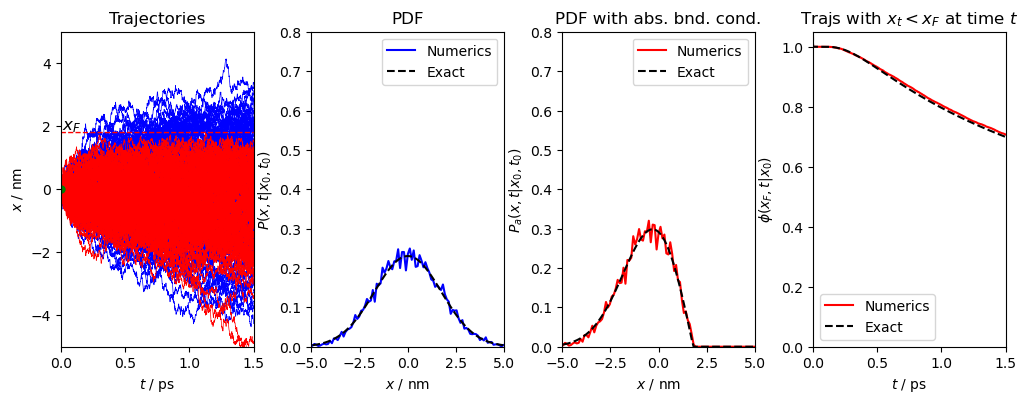

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24*in2cm, 8*in2cm), facecolor='white')  

xx  = x
xxf = x[:,xcf==0]

ax1.plot(t, xx[:,0:: 50], 'b-', linewidth = 0.5);
ax1.plot(t, xxf[:,0::50], 'r-', linewidth = 0.5);

ax1.plot(t0, x0, 'go', markersize = 5);
ax1.plot(t, xF * np.ones(t.shape), 'r--', linewidth = 1);
ax1.set_xlabel(r'$t$ / ps')
ax1.set_ylabel(r'$x$ / nm')
ax1.text(10*dt, xF + 0.1, r'$x_F$', fontsize = 12)
ax1.set_xlim(t0,tmax)
ax1.set_ylim(xmin, xmax)
ax1.set_title('Trajectories')

ax2.plot(xcenters, H, 'b',      label = 'Numerics')
ax2.plot(xcenters, P, 'k--', label = 'Exact')
ax2.set_xlabel(r'$x$ / nm')
ax2.set_ylabel(r'$P(x,t|x_0,t_0)$')
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(0,0.8)
ax2.legend()
ax2.set_title(r'PDF')

ax3.plot(xcenters, Ha, 'r',      label = 'Numerics')
ax3.plot(xcenters, Pa, 'k--', label = 'Exact')
ax3.set_xlabel(r'$x$ / nm')
ax3.set_ylabel(r'$P_a(x,t|x_0,t_0)$')
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(0,0.8)
ax3.legend()
ax3.set_title(r'PDF with abs. bnd. cond.')

ax4.plot(t, Phi, 'r',      label   = 'Numerics')
ax4.plot(t, Phi_ex, 'k--',      label = 'Exact')
ax4.set_xlabel(r'$t$ / ps')
ax4.set_ylabel(r'$\phi(x_F,t|x_0)$')
ax4.set_xlim(t0, tmax)
ax4.set_ylim(0,1.05)
ax4.legend()
ax4.set_title(r'Trajs with $x_t < x_F$ at time $t$')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.5);

#fig.savefig('figures/potential.png', format='png', dpi=900, bbox_inches='tight')

## Double well potential

In [8]:
# Grid
xbins     =  100
xmin      = - 3
xmax      = - xmin

xedges    = np.linspace(xmin, xmax, xbins)  # array with x edges
dx        = xedges[1] - xedges[0]
xcenters  = xedges + 0.5* dx
xcenters  = np.delete(xcenters,-1)
xbins     = len(xcenters)


def gradVx(x):
    return 4 * x * ( x**2 - 1 )

t0      = 0
tmax    = 10
dt      = 0.001

t       = np.arange(t0, tmax+dt, dt)
Nsteps  = len(t)
print(Nsteps)

Nreps  = 50000
x0     = 0
x      = np.zeros((Nsteps, Nreps))
x[0,:] = x0

D      = 1.0
sigma  = np.sqrt(2*D)
sdt    = np.sqrt(dt)

# final point
xF        = 1.0
arg_xF    = np.argmin(np.abs(xcenters - xF))

# First passage time of each replica
x_cross_xF       = np.zeros((Nsteps, Nreps))

# array of x values from xmin to xF --> to be used with phi_func()
xcentersF = xcenters[0:arg_xF]

# Fraction of trajectories hat did not reach xF at time t
Phi       = np.zeros(Nsteps)
Phi[0]    = np.sum( x[0,:] < xF ) / Nreps

#while np.sum(fpt==0)>0:
for k in range(Nsteps-1):

    F      = - gradVx(x[k,:])
    
    eta    = np.random.normal(0, 1, Nreps)

    x[k+1,:] = x[k,:] + D * F * dt + sigma * eta * sdt

    x_cross_xF[k+1,:] = x_cross_xF[k,:]
    x_cross_xF[k+1, ( x[k+1,:] >= xF ) & ( x_cross_xF[k+1,:] == 0 ) ] = 1
    
    Phi[k+1] = np.sum( (x[k+1,:] < xF) & ( x_cross_xF[k+1,:] == 0 ) ) / Nreps


# Histogram
xcf   = x_cross_xF[-1,:]
H, _  = np.histogram(x[-1,:], xedges, density=True)
Ha, _ = np.histogram(x[-1,xcf==0], xedges, density=True)

10001


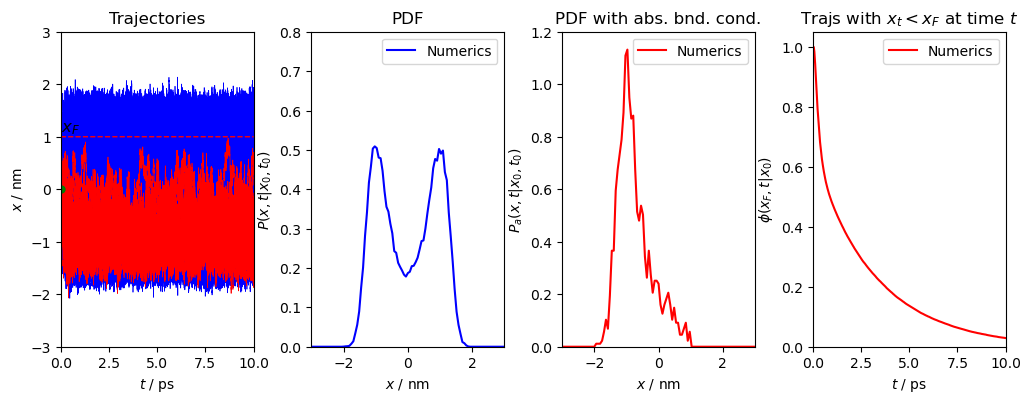

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24*in2cm, 8*in2cm), facecolor='white')  


xx  = x
xxf = x[:,xcf==0]

ax1.plot(t, xx[:,0:: 50], 'b-', linewidth = 0.5);
ax1.plot(t, xxf[:,0::50], 'r-', linewidth = 0.5);

ax1.plot(t0, x0, 'go', markersize = 5);
ax1.plot(t, xF * np.ones(t.shape), 'r--', linewidth = 1);
ax1.set_xlabel(r'$t$ / ps')
ax1.set_ylabel(r'$x$ / nm')
ax1.text(10*dt, xF + 0.1, r'$x_F$', fontsize = 12)
ax1.set_xlim(t0,tmax)
ax1.set_ylim(xmin, xmax)
ax1.set_title('Trajectories')

ax2.plot(xcenters, H, 'b',      label = 'Numerics')
ax2.set_xlabel(r'$x$ / nm')
ax2.set_ylabel(r'$P(x,t|x_0,t_0)$')
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(0,0.8)
ax2.legend()
ax2.set_title(r'PDF')

ax3.plot(xcenters, Ha, 'r',      label = 'Numerics')
ax3.set_xlabel(r'$x$ / nm')
ax3.set_ylabel(r'$P_a(x,t|x_0,t_0)$')
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(0,1.2)
ax3.legend()
ax3.set_title(r'PDF with abs. bnd. cond.')

ax4.plot(t, Phi, 'r',      label = 'Numerics')
ax4.set_xlabel(r'$t$ / ps')
ax4.set_ylabel(r'$\phi(x_F,t|x_0)$')
ax4.set_xlim(t0, tmax)
ax4.set_ylim(0,1.05)
ax4.legend()
ax4.set_title(r'Trajs with $x_t < x_F$ at time $t$')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.5);

#fig.savefig('figures/potential.png', format='png', dpi=900, bbox_inches='tight')

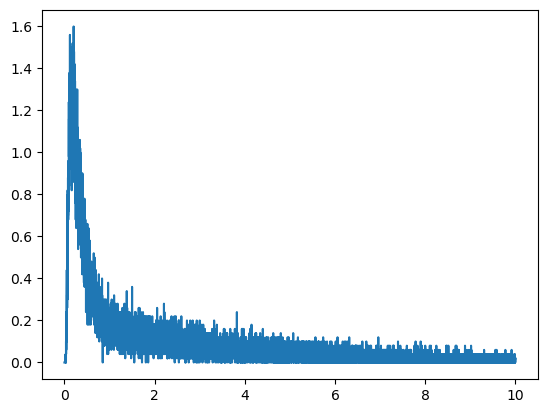

In [10]:
plt.plot(t[0:-1],-np.diff(Phi)/dt)

In [11]:
Pa.shape

(99,)